__Simple Gaussian example__:

 * use 2 gaussian to represent data
 * construct graph 
 * spectral cluster with normalized and unnormalized laplacian
 * plot new representation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
mean1 = [-2, -2]
cov1 = [[1, 0], [0, 1]]  # diagonal covariance
mean2 = [2,2]
cov2 = [[1, 0], [0, 1]]  # diagonal covariance

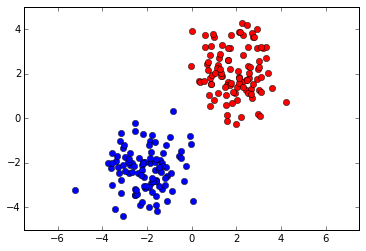

In [5]:
x = np.zeros(200)
y = np.zeros(200)
x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
x[100:], y[100:] = np.random.multivariate_normal(mean2, cov2, 100).T
plt.plot(x[:100], y[:100], 'bo')
plt.plot(x[100:], y[100:], 'ro')
plt.axis('equal')
plt.show()

In [9]:
def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 1
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))
#constructing graph
W = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        W[i,j] = similarity((x[i],y[i]),(x[j],y[j]))
print W[12,23], W[23,12]

0.102280308262 0.102280308262


In [20]:
D = np.diag(np.dot(W,np.ones(200)))
L = D - W

In [29]:
eigenValues , eigenVectors = np.linalg.eig(L)
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

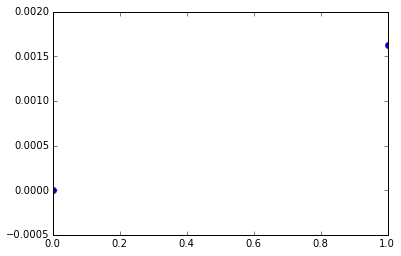

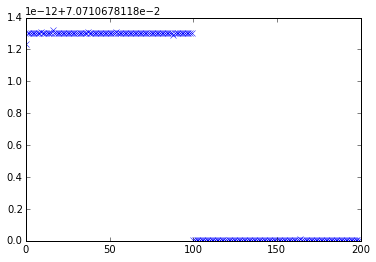

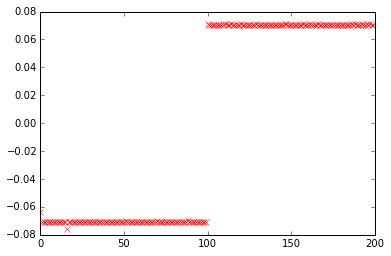

In [44]:
plt.plot(range(2),eigenValues[:2],'bo')
plt.show()
plt.plot(range(200),eigenVectors[:,0],'x')
plt.show()
plt.plot(range(200),eigenVectors[:,1],'rx')
plt.show()

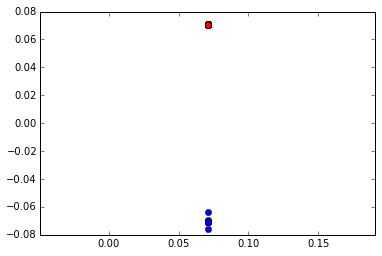

In [42]:
xt = eigenVectors[:,0]
yt = eigenVectors[:,1]
plt.plot(xt[:100], yt[:100], 'bo')
plt.plot(xt[100:], yt[100:], 'ro')
plt.axis('equal')
plt.show()

__Generalized__

In [45]:
import scipy as sp
D = np.diag(np.dot(W,np.ones(200)))
L = D - W
eigenValues , eigenVectors = sp.linalg.eig(L,D)
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

c:\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


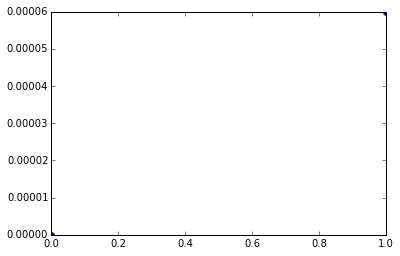

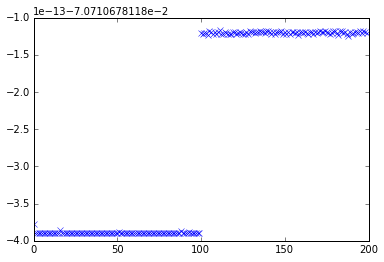

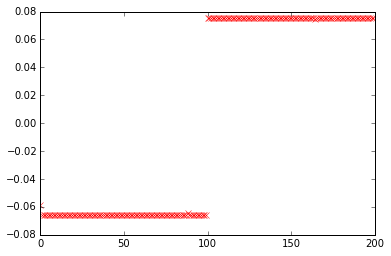

In [46]:
plt.plot(range(2),eigenValues[:2],'bo')
plt.show()
plt.plot(range(200),eigenVectors[:,0],'x')
plt.show()
plt.plot(range(200),eigenVectors[:,1],'rx')
plt.show()

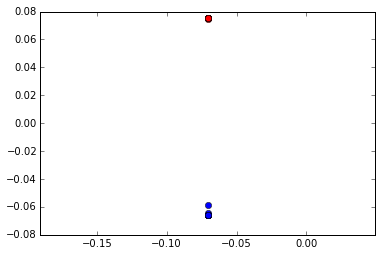

In [47]:
xt = eigenVectors[:,0]
yt = eigenVectors[:,1]
plt.plot(xt[:100], yt[:100], 'bo')
plt.plot(xt[100:], yt[100:], 'ro')
plt.axis('equal')
plt.show()

__Normalized__

In [59]:
d = np.diag(D)
d1 = 1/np.sqrt(d)
D1 = np.diag(d1)
D1

array([[ 0.72496635,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.23542579,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.23649362, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.24227626,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.15914811,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.1563587 ]])

In [60]:
D = np.diag(np.dot(W,np.ones(200)))
L = D - W
Lsym = np.dot(np.dot(D1,L),D1)

eigenValues , eigenVectors = np.linalg.eig(Lsym)
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

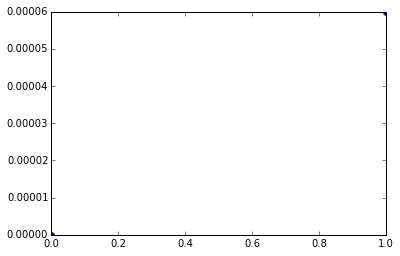

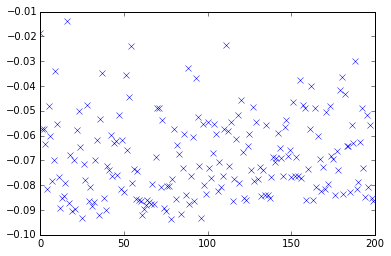

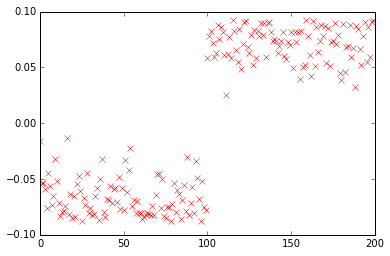

In [61]:
plt.plot(range(2),eigenValues[:2],'bo')
plt.show()
plt.plot(range(200),eigenVectors[:,0],'x')
plt.show()
plt.plot(range(200),eigenVectors[:,1],'rx')
plt.show()

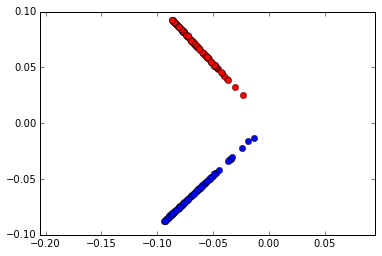

In [62]:
xt = eigenVectors[:,0]
yt = eigenVectors[:,1]
plt.plot(xt[:100], yt[:100], 'bo')
plt.plot(xt[100:], yt[100:], 'ro')
plt.axis('equal')
plt.show()